In [3]:
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize_scalar, minimize
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd.numpy import linalg
from numpy import linalg
import math
import autograd.scipy as scipy
from scipy import optimize
import copy

In [4]:
def generateAUI(m, n):
    U = np.zeros((m, m))
    I = np.eye(n-m)
    for i in range(m):
        U[i][i] = 1
        if (i + 1 < m):
            U[i][i + 1] = -1
    Am = np.block([[U, np.zeros((m, n - m))], [np.zeros((n - m, m)), I]])        
    return Am    

In [5]:
size = 10
N = 10
NumIter = 10
L = 10
#L1 = 5
TensorNumIter = 20
tau = 1.01
eps = 1e-4

#tau = [1.01, 10, 1000]
#A_func, b = generateAb(L1, N, size)
B = np.eye(size)
m = N // 2
Am = generateAUI(m, size)

from autograd import grad    
from autograd import jacobian

p = 3
def f(x):
    #return np.dot(x, x.T) * np.dot(x, x.T)
    #return np.dot(0.5*np.dot(A_func, x) - b, x)

    # Universal bad function
    sum_Axn = 0
    Axn = np.dot(Am, x)
    for i in range(size):
        sum_Axn = sum_Axn + np.power(np.abs(x[i]), p + 1)
    sum_Axn = 1./ (p + 1) * sum_Axn
    return sum_Axn - x[0]
    
#nx = np.array([1., 1., 3.])
grad_f = grad(f)       # Obtain its gradient function
#print(grad_f(nx))         

hess_f = jacobian(grad_f)
#print(hess_f(nx))

tensor3_f = jacobian(hess_f)
#print(tensor3_f(nx))

def TrueVec(A, b):
    return linalg.solve(A, b)

def TrueAns(A, b):
    return f(TrueVec(A, b))

In [6]:
def calc_cur_params(grad_f_cur, hessian_f_cur, tensor3_f_cur, hk, tau, L):
    grad_d = np.dot(hk, hk.T)*hk
    c = (grad_f_cur - 1/tau*np.dot(hessian_f_cur, hk.T) + 0.5*np.dot(np.dot(tensor3_f_cur, hk.T), hk.T) 
                                                                        - tau*(tau + 1)/2*L*grad_d)
    
    A = (tau + 1) / tau * hessian_f_cur
    
    gamma = tau*(tau + 1)/2*L
    return c, A, gamma

In [7]:
def aux_problem_func(h, *args):
    c, A, gamma = args
    #d = linalg.norm(h + hk)
    d = linalg.norm(h)
    d4 = d*d*d*d
    return np.dot(c, h) + 0.5 * np.dot(np.dot(A, h), h) + 0.25*gamma*d4 

def aux_problem_onedim_func(t, *args):
    c, A, B, gamma = args
    #print('aux ------------- ', gamma, t, B, A)
    sgam = math.sqrt(2*gamma)
    S = sgam*t*B + A
    
    invS = linalg.inv(S)
    #print('1', 0.5*t*t)
    #dop = c + sgam*t*hk
    f = 0.5*t*t + 0.5 * np.dot(np.dot(invS, c), c)
    #print('2', f, linalg.norm(S), linalg.norm(invS), linalg.norm(np.dot(S, invS)))
    
    return f

In [8]:
def calc_hopt(t, *args):
    c, A, B, gamma = args
    S = math.sqrt(2*gamma)*t*B + A
    invS = linalg.inv(S)
    h_opt = - np.dot(invS, c)
    return h_opt

In [9]:
def T3M(x, aux_prob_method, grad_f, hess_f, tensor3_f, TensorMaxIter, tau, L, eps):
    
    size = x.shape[0]
    hk = np.zeros(size)
    B = np.eye(size)
 
    if aux_prob_method == 1:
        xb = L*1e10
        t0 = 0+eps
    
    grad_f_cur = grad_f(x)
    hessian_f_cur = hess_f(x)
    tensor3_f_cur = tensor3_f(x)
    for aux_k in range(1, TensorMaxIter + 1):
        c, A, gamma = calc_cur_params(grad_f_cur, hessian_f_cur, tensor3_f_cur, hk, tau, L)
            
        if aux_prob_method == 1:
            allargs = (c, A, B, gamma)

            res = optimize.minimize_scalar(aux_problem_onedim_func, args = allargs, method = 'bounded', bounds=(t0, xb), tol = eps)
            #res = minimize_scalar(aux_problem_onedim_func, args = allargs), bounds=(t0, xb), tol = eps)
            
            tau_opt = res.x
            #if aux_k % 10 == 0:
            #print('in - num_it, tau_opt, f_opt, status', aux_k, tau_opt, res.fun, res.success)
            
            #t1 = np.arange(t0, 350, 1)
            #y = [aux_problem_onedim_func(i, *allargs) for i in t1]
            #plt.plot(t1, y)
            #plt.show()
            
            h_opt = calc_hopt(tau_opt, *(c, A, B, gamma))
            #print('in-h', h_opt)
                
        elif aux_prob_method == 2:
            allargs = (c, A, gamma)
        
            res = optimize.minimize(aux_problem_func, args = allargs, tol = eps, x0 = hk, method = 'Powell')                
            h_opt = res.x
            #print('inSciPy', res.fun, "h_opt = ", res.x)
                
        #if (res.status != 0):
         #   print("Error: minimize_scalar: ", res)
      
        #print('inn ', 'h_opt', h_opt)
        hk = h_opt #+ hk
    return (hk + x)      

##### Tensor method by Yu. Nesterov (2018)
Parameters:  
$NumIter$ --- max number of steps in tensor method  
$TensorMaxIter$ --- max number of iterations in auxiliary problem solution method (5.8)  
$x0$ --- initial point  
$f$ --- objective function oracle  
$p$ --- order of method ($p = 2$ or $p = 3$)  
$aux\_prob\_method$ --- how to solve auxiliary problem (5.4): $1$ --- by means of method (5.8), $2$ --- by means of $scipy.optimize$  

In [10]:
def Tensor3_iter(NumIter, TensorMaxIter, x0, f, grad_f, hess_f, tensor3_f, tau, L, eps, aux_prob_method):
        
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    xk = copy.deepcopy(x0)
    
    f_xk = f(xk)
    gradf_xk = grad_f(xk)
    farr[0] = f_xk
    fgradarr[0] = linalg.norm(gradf_xk)
    for k in range(1, NumIter + 1):
        xk = T3M(xk, aux_prob_method, grad_f, hess_f, tensor3_f, TensorMaxIter, tau, L, eps)        
        #print(xk)
        f_xk = f(xk)
        gradf_xk = grad_f(xk)
        farr[k] = f_xk
        fgradarr[k] = linalg.norm(gradf_xk)
        
        ##if k % 10 == 0:
          ##  print('k, f_xk', k, f_xk)
            
        #if abs(f_xk) < eps:
         #   break
    
    return xk, f_xk, farr, fgradarr##, k
    
    

In [11]:
def proxd(x, p):
    return 1. / p * (linalg.norm(x)**p) 

##### Accelerated tensor method by Yu. Nesterov (2018)

In [12]:
def TensorAcc3_iter(NumIter, TensorMaxIter, x0, f, grad_f, hess_f, tensor3_f, tau, L, eps, aux_prob_method):
    
    xk = copy.deepcopy(x0)
    M = tau*tau*L
    
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    
    f_xk = f(xk)
    gradf_xk = grad_f(xk)
    farr[0] = f_xk
    fgradarr[0] = linalg.norm(gradf_xk)

    
    xk = T3M(xk, aux_prob_method, grad_f, hess_f, tensor3_f, TensorMaxIter, tau, L, eps)
    #print('xk = {0}'.format(xk))
    f_xk = f(xk)
    gradf_xk = grad_f(xk)
    farr[1] = f_xk
    fgradarr[1] = linalg.norm(gradf_xk)
    
    p = 3
    C = p / 2 * math.sqrt((p+1)/(p-1)*(M*M - L*L))
    
    min_psik = copy.deepcopy(x0)
    sk = np.zeros(size)
    
    ak_part = math.sqrt(pow((p - 1) * (M*M - L*L) / 4 / (p + 1) / M / M, p))
    k = 1
    Ak1 = ak_part*pow(k / (p + 1), p + 1)
    
    factor_p = math.factorial(p)
    
    for k in range(1, NumIter):
        vk = min_psik
        Ak = Ak1
        Ak1 = ak_part*pow((k + 1) / (p + 1), p + 1)
        alpha = Ak / Ak1
        #print('alpha = {0}'.format(alpha))
        yk = alpha * xk + (1 - alpha) * vk
        #print('yk = {0}'.format(yk))
        
        xk = T3M(yk, aux_prob_method, grad_f, hess_f, tensor3_f, TensorMaxIter, tau, L, eps)        
        #print('xk = {0}'.format(xk))

        a = Ak1 - Ak
        sk = sk + a * grad_f(xk) 
        min_psik = x0 - pow(factor_p / C / pow(linalg.norm(sk), p - 1), 1. / p) * sk
        
        f_xk = f(xk)
        gradf_xk = grad_f(xk)
        farr[k + 1] = f_xk
        fgradarr[k + 1] = linalg.norm(gradf_xk)
        
        #if k % 10 == 0:
         #   print('k, f_xk, xk', k, f_xk, xk)
            
        #if abs(f_xk) < eps:
           # break
    
    return xk, f_xk, farr, fgradarr#, k
    

In [13]:
def FGM_iter(NumIter, x0, f, gradf, *args):
    #A, b, L = args
    k = 0
    v_k = copy.deepcopy(x0)
    x_k = copy.deepcopy(x0)
    A_k = 0
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    farr[0] = f(x_k)
    fgradarr[0] = linalg.norm(gradf(x_k))
    while (k < NumIter):
        a_k = (1 + (1 + 2 * L * A_k)**0.5) / L 
        y_k = (A_k*x_k + a_k*v_k)/(A_k + a_k)
        x_k = y_k - 1/L*gradf(y_k)#, *(A, b))
        gradf_xk = gradf(x_k)#, *(A, b))
        v_k = v_k - a_k * gradf_xk
        A_k = A_k + a_k
        k += 1
        f_xk = f(x_k)#, *(A, b))
        farr[k] = f_xk
        fgradarr[k] = linalg.norm(gradf_xk)
        #if abs(f_xk) < eps:
         #   break
    return x_k, farr, k, fgradarr

In [14]:
def Newton_cubic_step(x_k, NumIterStep, *args):
    g, H, M, eps = args
    g_new = g*M/2
    lambda_ans = eps
    k = 0
    while (k < NumIterStep):
        H_lambda = H + lambda_ans*np.identity(H.shape[0])
        L = linalg.cholesky(H_lambda)
        s = linalg.solve(H_lambda, -g_new)
        w = linalg.solve(L, s)
        lambda_next = lambda_ans*(1 - 
            (lambda_ans - linalg.norm(s))*(linalg.norm(s)**2)/(linalg.norm(s)**3 + (linalg.norm(w)**2)*(lambda_ans**2)))
        if (lambda_next > 0):
            lambda_ans = lambda_next
        else:
            break
        k += 1
    H_lambda = H + lambda_ans*np.identity(H.shape[0])
    s = linalg.solve(H_lambda, -g_new)
    r_opt1 = lambda_ans*2/M
    print("||s|| - lambda = {0}".format(linalg.norm(s) - lambda_ans))
    r_opt2 = 0
    h_opt1 = -np.dot(linalg.inv(H + M/2*r_opt1*np.identity(H.shape[0])), g)
    h_opt2 = -np.dot(linalg.pinv(H), g)
    val_1 = np.dot(g, h_opt1) + 1/2*np.dot(np.dot(H, h_opt1), h_opt1) + M/6*(linalg.norm(h_opt1)**3)
    val_2 = np.dot(g, h_opt2) + 1/2*np.dot(np.dot(H, h_opt2), h_opt2) + M/6*(linalg.norm(h_opt2)**3)
    if (val_1 < val_2):
        h_opt = h_opt1
    else:
        h_opt = h_opt2
    return x_k + h_opt

def Newton_cubic_solver_iter(x0, NumIter, NumIterStep, f, grad_f, hessian_f, L0, eps, *args):
    k = 0
    x_k = copy.deepcopy(x0)
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    M_k = L0
    while (k < NumIter):
        print("iter = {0}".format(k))
        f_current = f(x_k, *args)
        grad_f_current = grad_f(x_k, *args)
        hessian_f_current = hessian_f(x_k, *args)
        farr[k] = f_current
        fgradarr[k] = linalg.norm(grad_f_current)
        while(1):
            T_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, M_k, eps))
            if (f(T_k) > f_current):
                M_k = 2*M_k
                print("M_k = {0}".format(M_k))
            else:
                break
        x_k = T_k
        M_k = max(1/2*M_k, L0)
        k += 1
    f_current = f(x_k)
    grad_f_current = grad_f(x_k)
    farr[k] = f_current
    fgradarr[k] = linalg.norm(grad_f_current)
    return x_k, farr, fgradarr
    
#L0 = 1e-10
L0 = L

In [15]:
x0 = np.zeros(size)

print("Константа L = {0}".format(L))

aux_prob_method = 1
xans1, fans1, farr1, fgradarr1 = Tensor3_iter(NumIter, TensorNumIter, 
                                     x0, f, grad_f, hess_f, tensor3_f, tau, L, eps, aux_prob_method)
print('1xans ', xans1)
print('1fans, it1 ', fans1, NumIter)

aux_prob_method = 2
xans2, fans2, farr2, fgradarr2 = Tensor3_iter(NumIter, TensorNumIter, 
                                     x0, f, grad_f, hess_f, tensor3_f, tau, L, eps, aux_prob_method)
print('2xans ', xans2)
print('2fans, it2 ', fans2, NumIter)

aux_prob_method = 1
xans3, fans3, farr3, fgradarr3 = TensorAcc3_iter(NumIter, TensorNumIter, 
                                     x0, f, grad_f, hess_f, tensor3_f, tau, L, eps, aux_prob_method)
print('3xans ', xans3)
print('3fans, it3 ', fans3, NumIter)

aux_prob_method = 2
xans4, fans4, farr4, fgradarr4 = TensorAcc3_iter(NumIter, TensorNumIter, 
                                     x0, f, grad_f, hess_f, tensor3_f, tau, L, eps, aux_prob_method)
print('4xans ', xans4)
print('4fans, it4 ', fans4, NumIter)

xans_fgm, farr_fgm, it_fgm, fgradarr_fgm = FGM_iter(NumIter, x0, f, grad_f)
print('5xans_fgm ', xans_fgm)
print('5fans_fgm, it5 ', farr_fgm[NumIter], NumIter)

NumIterStep = TensorNumIter
xans_newton_cubic_iter, farr_newton_cubic_iter, fgradarr_newton_cubic_iter = Newton_cubic_solver_iter(x0, NumIter, 
                        NumIterStep, f, grad_f, hess_f, L0, eps)
print('6xans_newton ', xans_newton_cubic_iter)
print('6xans_newton, it6 ', farr_newton_cubic_iter[NumIter], NumIter)



Константа L = 10


/usr/local/lib/python3.5/dist-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/usr/local/lib/python3.5/dist-packages/scipy/optimize/_minimize.py:763: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


1xans  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1fans, it1  -0.75 10
2xans  [ 1.00000000e+00  1.84395206e-10  1.95717331e-10  2.01915556e-10
 -1.51555200e-10 -1.51929571e-10 -2.19509700e-10 -2.39362874e-10
  1.68747592e-10  2.26490443e-10]
2fans, it2  -0.75 10
3xans  [1.01896809 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
3fans, it3  -0.7494534603217553 10
4xans  [ 1.01896951e+00  2.75006342e-08 -4.10666114e-09 -3.18228462e-09
  2.75314428e-09  3.03190897e-09  2.96036877e-09 -1.72753292e-09
  2.34865259e-09  2.55130668e-09]
4fans, it4  -0.7494533781893369 10
5xans_fgm  [1.00251809 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
5fans_fgm, it5  -0.7499904728292186 10
iter = 0
||s|| - lambda = 0.0
iter = 1
||s|| - lambda = 0.0
iter = 2
||s|| - lambda = 1.1102230246251565e-16
iter = 3
||s|| - lambda = 0.0
iter = 4
||s|| - lambda = 0.0
iter = 5
||s|| - lambda = -9.971569171524939e-05
iter = 6
||s|| - lambd

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


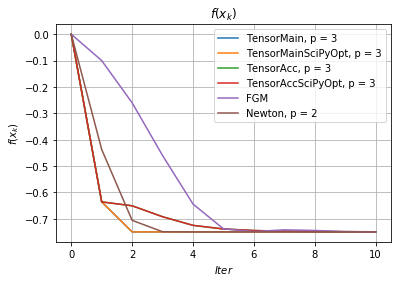

In [16]:
fig = plt.figure()
plt.xlabel(r'$Iter$') 
plt.ylabel(r'$f(x_k)$') 
plt.title(r'$f(x_k)$') 

plt.plot([i for i in range(NumIter + 1)], farr1, label = 'TensorMain, p = 3')
plt.plot([i for i in range(NumIter + 1)], farr2, label = 'TensorMainSciPyOpt, p = 3')
plt.plot([i for i in range(NumIter + 1)], farr3, label = 'TensorAcc, p = 3')
plt.plot([i for i in range(NumIter + 1)], farr4, label = 'TensorAccSciPyOpt, p = 3')
plt.plot([i for i in range(NumIter + 1)], farr_fgm, label = 'FGM')
plt.plot([i for i in range(NumIter + 1)], farr_newton_cubic_iter, label = 'Newton, p = 2')

plt.legend()
plt.grid(True) 
#fig.savefig('Tensor3_f_iter.pdf')
plt.show()

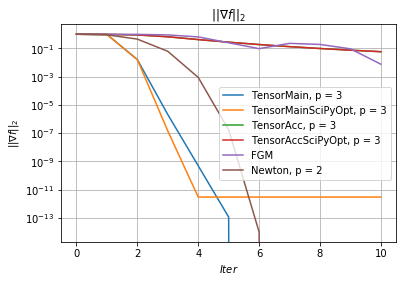

In [17]:
#fig = plt.figure()
plt.xlabel(r'$Iter$') 
plt.ylabel(r'$||\nabla f||_2$') 
plt.title(r'$||\nabla f||_2$')

plt.semilogy([i for i in range(NumIter + 1)], fgradarr1, label = 'TensorMain, p = 3')
plt.semilogy([i for i in range(NumIter + 1)], fgradarr2, label = 'TensorMainSciPyOpt, p = 3')
plt.semilogy([i for i in range(NumIter + 1)], fgradarr3, label = 'TensorAcc, p = 3')
plt.semilogy([i for i in range(NumIter + 1)], fgradarr4, label = 'TensorAccSciPyOpt, p = 3')
plt.semilogy([i for i in range(NumIter + 1)], fgradarr_fgm, label = 'FGM')
plt.semilogy([i for i in range(NumIter + 1)], fgradarr_newton_cubic_iter, label = 'Newton, p = 2')

plt.legend()
plt.grid(True) 
#fig.savefig('Tensor3_gradf_iter.pdf')

In [18]:
def Tensor3_iter_print_hist(NumIter, TensorMaxIter, x0, f, grad_f, hess_f, tensor3_f, tau, L, eps, aux_prob_method):
        
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    xk = copy.deepcopy(x0)
    
    f_xk = f(xk)
    gradf_xk = grad_f(xk)
    farr[0] = f_xk
    fgradarr[0] = linalg.norm(gradf_xk)
    for k in range(1, NumIter + 1):
        xk = T3M(xk, aux_prob_method, grad_f, hess_f, tensor3_f, TensorMaxIter, tau, L, eps)        
        print(xk)
        f_xk = f(xk)
        gradf_xk = grad_f(xk)
        farr[k] = f_xk
        fgradarr[k] = linalg.norm(gradf_xk)
        
        ##if k % 10 == 0:
          ##  print('k, f_xk', k, f_xk)
            
        #if abs(f_xk) < eps:
         #   break
    
    return xk, f_xk, farr, fgradarr##, k

def TensorAcc3_iter_print_hist(NumIter, TensorMaxIter, x0, f, grad_f, hess_f, tensor3_f, tau, L, eps, aux_prob_method):
    
    xk = copy.deepcopy(x0)
    M = tau*tau*L
    
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    
    f_xk = f(xk)
    gradf_xk = grad_f(xk)
    farr[0] = f_xk
    fgradarr[0] = linalg.norm(gradf_xk)

    
    xk = T3M(xk, aux_prob_method, grad_f, hess_f, tensor3_f, TensorMaxIter, tau, L, eps)
    print('xk = {0}'.format(xk))
    f_xk = f(xk)
    gradf_xk = grad_f(xk)
    farr[1] = f_xk
    fgradarr[1] = linalg.norm(gradf_xk)
    
    p = 3
    C = p / 2 * math.sqrt((p+1)/(p-1)*(M*M - L*L))
    
    min_psik = copy.deepcopy(x0)
    sk = np.zeros(size)
    
    ak_part = math.sqrt(pow((p - 1) * (M*M - L*L) / 4 / (p + 1) / M / M, p))
    k = 1
    Ak1 = ak_part*pow(k / (p + 1), p + 1)
    
    factor_p = math.factorial(p)
    
    for k in range(1, NumIter):
        vk = min_psik
        Ak = Ak1
        Ak1 = ak_part*pow((k + 1) / (p + 1), p + 1)
        alpha = Ak / Ak1
        print('alpha = {0}'.format(alpha))
        yk = alpha * xk + (1 - alpha) * vk
        print('yk = {0}'.format(yk))
        
        xk = T3M(yk, aux_prob_method, grad_f, hess_f, tensor3_f, TensorMaxIter, tau, L, eps)        
        print('xk = {0}'.format(xk))

        a = Ak1 - Ak
        sk = sk + a * grad_f(xk) 
        min_psik = x0 - pow(factor_p / C / pow(linalg.norm(sk), p - 1), 1. / p) * sk
        
        f_xk = f(xk)
        gradf_xk = grad_f(xk)
        farr[k + 1] = f_xk
        fgradarr[k + 1] = linalg.norm(gradf_xk)
        
        #if k % 10 == 0:
         #   print('k, f_xk, xk', k, f_xk, xk)
            
        #if abs(f_xk) < eps:
           # break
    
    return xk, f_xk, farr, fgradarr#, k

In [19]:
aux_prob_method = 1
xans3, fans3, farr3, fgradarr3 = TensorAcc3_iter_print_hist(NumIter, TensorNumIter, 
                                     x0, f, grad_f, hess_f, tensor3_f, tau, L, eps, aux_prob_method)

/usr/local/lib/python3.5/dist-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/usr/local/lib/python3.5/dist-packages/scipy/optimize/_minimize.py:763: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


xk = [1.25366951 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
alpha = 0.0625
yk = [0.07835434 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
xk = [1.23788727 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
alpha = 0.19753086419753085
yk = [0.22101688 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
xk = [1.18438238 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
alpha = 0.31640625
yk = [0.34245289 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
xk = [1.12360454 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
alpha = 0.4096
yk = [0.42342536 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
xk = [1.0838132 0.        0.        0.     

In [20]:
aux_prob_method = 1
xans1, fans1, farr1, fgradarr1 = Tensor3_iter_print_hist(NumIter, TensorNumIter, 
                                     x0, f, grad_f, hess_f, tensor3_f, tau, L, eps, aux_prob_method)

/usr/local/lib/python3.5/dist-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/usr/local/lib/python3.5/dist-packages/scipy/optimize/_minimize.py:763: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


[1.25366951 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.99466023 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.99999932 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
